In [2]:
# import dependencies
import os 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import  random_split
import torch
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import albumentations as albu
from torchvision.transforms import ToTensor


In [3]:
# Helper functions 
## helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In [4]:
# preprocess blender corn mask 
def blender_corn_mask_preprocess(im): 
    #convert rgba to rgb 
    im = im.convert('RGB')
    width, height = im.size
    left = (width - 960) / 2
    top = (height - 640) / 2
    right = (width + 960) / 2
    bottom = (height + 640) / 2
    # 居中裁剪
    im = im.crop((left, top, right, bottom))
    im = im.resize((480,320))
    # convert all (200, 200, 200) above to white, others to black 
    for x in range(im.width):
        for y in range(im.height):
            # Get the RGB value of the pixel
            r, g, b = im.getpixel((x, y))

            if r >200 and g>200 and b >200:
                # Convert the pixel to white
                im.putpixel((x, y), (255, 255, 255))
            else:
                im.putpixel((x, y), (0, 0, 0))
    im = im.convert('L')
    return im 
# preprocess gazebo corn raw
def blender_corn_raw_preprocess(im): 
    im = im.convert('RGB')
    width, height = im.size
    left = (width - 960) / 2
    top = (height - 640) / 2
    right = (width + 960) / 2
    bottom = (height + 640) / 2
    # 居中裁剪
    im = im.crop((left, top, right, bottom))
    im = im.resize((480,320))
    return im

In [5]:
# blender rand pre
# preprocess blender corn mask 
def blender_rand_mask_preprocess(im): 
    #convert rgba to rgb 
    im = im.convert('RGB')
    # convert all (200, 200, 200) above to white, others to black 
    for x in range(im.width):
        for y in range(im.height):
            # Get the RGB value of the pixel
            r, g, b = im.getpixel((x, y))

            # Check if the pixel is green (has a high green component)
            if r >200 and g>200 and b >200:
                # Convert the pixel to white
                im.putpixel((x, y), (255, 255, 255))
            else:
                im.putpixel((x, y), (0, 0, 0))
    im = im.convert('L')
    return im 
# preprocess gazebo corn raw
def blender_rand_raw_preprocess(im): 
    im = im.convert('RGB')
    return im

In [6]:
# dataset 
# Dataset
class Dataset(BaseDataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            raw_preprocessing=None,
            mask_preprocessing = None,
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
    ):
        filenames = os.listdir(images_dir)
        raw_suffix = "_raw.png"
        tag_suffix = "_tag.png"
        self.ids = [filename[:-len(raw_suffix)] for filename in filenames]
        self.ids.sort()
        self.images_fps = [os.path.join(images_dir, f"{image_id}{raw_suffix}") for image_id in self.ids]
        self.masks_fps =[os.path.join(masks_dir, f"{image_id}{tag_suffix}") for image_id in self.ids]
        self.augmentation = augmentation
        self.raw_preprocessing = raw_preprocessing
        self.mask_preprocessing = mask_preprocessing
        self.mean = mean 
        self.std = std 

    def __getitem__(self, i):
        # read raw image 
        image = Image.open(self.images_fps[i])

        # preprocessing raw image 
        if self.raw_preprocessing:
            image = self.raw_preprocessing(image)
        
        # read mask iamge 
        mask = Image.open(self.masks_fps[i])

        # preprocess mask image 
        if self.mask_preprocessing:
            mask = self.mask_preprocessing(mask)

        # apply augmentations to raw image 
        if self.augmentation:
            sample = self.augmentation(image=np.array(image), mask=np.array(mask))
            image, mask = sample['image'], sample['mask']

    
        # convert raw image to tensor 
        raw_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,
                                std=self.std)
        ])
        image = raw_transform(image)
        # convert black and white iamge to tensor 
        mask_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        mask = mask_transform(mask)
        return image, mask 
    
    def __len__(self):
        return len(self.ids)

In [7]:
class Dataset2(BaseDataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            raw_preprocessing=None,
            mask_preprocessing = None,
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
    ):
        filenames = os.listdir(masks_dir)
        raw_suffix = ".JPG"
        tag_suffix = ".png"
        self.ids = [filename[:-len(raw_suffix)] for filename in filenames]
        self.ids.sort()
        self.images_fps = [os.path.join(images_dir, f"{image_id}{raw_suffix}") for image_id in self.ids]
        self.masks_fps =[os.path.join(masks_dir, f"{image_id}{tag_suffix}") for image_id in self.ids]
        self.augmentation = augmentation
        self.raw_preprocessing = raw_preprocessing
        self.mask_preprocessing = mask_preprocessing
        self.mean = mean 
        self.std = std 

    def __getitem__(self, i):
        # read raw image 
        image = Image.open(self.images_fps[i])

        # preprocessing raw image 
        if self.raw_preprocessing:
            image = self.raw_preprocessing(image)
        
        # read mask iamge 
        mask = Image.open(self.masks_fps[i])

        # preprocess mask image 
        if self.mask_preprocessing:
            mask = self.mask_preprocessing(mask)

        # apply augmentations to raw image 
        if self.augmentation:
            sample = self.augmentation(image=np.array(image), mask=np.array(mask))
            image, mask = sample['image'], sample['mask']

    
        # convert raw image to tensor 
        raw_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,
                                std=self.std)
        ])
        image = raw_transform(image)
        # convert black and white iamge to tensor 
        mask_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        mask = mask_transform(mask)
        return image, mask 
    
    def __len__(self):
        return len(self.ids)

In [8]:
#aug 
def get_training_augmentation1():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                albu.RandomGamma(gamma_limit=(80, 120), p=1),
                albu.CLAHE(p=0.5),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=0.5),
                albu.MedianBlur(blur_limit=3, p=0.3),
                albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                #albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.GridDistortion(p=1),
                #albu.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                #albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)
tran = get_training_augmentation1()

In [9]:
# load models 
DEVICE = 'cuda'

In [10]:
# input image output np array 
def apply_rand_crop(image):
    arr = np.array(image)
    # 创建Albumentations变换管道
    transform = albu.Compose([
        albu.RandomCrop(height=640, width=480, p=1.0),
    ])
    
    # 对输入图像应用变换
    augmented = transform(image=arr)
    
    # 从返回的字典中提取增强后的图像
    transformed_image = augmented['image']
    
    return transformed_image

def apply_center_crop(image):
    arr = np.array(image)
    # 创建Albumentations变换管道
    transform = albu.Compose([
        albu.CenterCrop(height=640, width=480, p=1.0),
    ])
    
    # 对输入图像应用变换
    augmented = transform(image=arr)
    
    # 从返回的字典中提取增强后的图像
    transformed_image = augmented['image']
    
    return transformed_image

def array2Tensor(means = [0.485, 0.456, 0.406],stds = [0.229, 0.224, 0.225], image_array = None):
    raw_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= means, std = stds)
    ])
    return raw_transform(image_array)


In [11]:
# predict a single image 
def predict_image(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(image = im, prediction = pr_mask )
# predict a single image 
def predict_image_2(image_path, model, model2):
    image = Image.open(image_path).convert('RGB')
    image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_mask2 = model2.predict(image_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask2 = (pr_mask2.squeeze().cpu().numpy().round())
    visualize(image = im, prediction1 = pr_mask, prediction2 = pr_mask2 )
# predict a single image 
def predict_image_withmask(image_path, mask_path, model):
    image = Image.open(image_path).convert('RGB')
    image = blender_corn_raw_preprocess(image)
    im = image
    mask = Image.open(mask_path).convert('RGB')
    mask = blender_corn_mask_preprocess(mask)
    m = mask 
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_tensor = pr_mask.squeeze().cpu().round()
    to_tensor = ToTensor()
    mask_tensor = to_tensor(mask)
    mask_tensor = mask_tensor.squeeze(0)
    print("IOU", iou_2d(pr_tensor, mask_tensor))
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(image = im, mask = m, prediction = pr_mask )

# predict a single image 
def predict_image_no_resize(image_path, model):
    image = Image.open(image_path).convert('RGB')
    #image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(image = im, prediction = pr_mask )
def predict_image_no_resize_2(image_path, model, model2):
    image = Image.open(image_path).convert('RGB')
    #image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask2 = model2.predict(image_tensor)
    pr_mask2 = (pr_mask2.squeeze().cpu().numpy().round())
    visualize(image = im, prediction1 = pr_mask, prediction2 = pr_mask2 )
# predict a single image 
def predict_image_resize(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((480,320))
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(image = im, prediction = pr_mask )
# predict a single image 
def predict_image_no_resize_withmask(image_path,mask_path, model):
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('RGB')
    mask = blender_rand_mask_preprocess(mask)
    m = mask 
    #image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_tensor = pr_mask.squeeze().cpu().round()
    to_tensor = ToTensor()
    mask_tensor = to_tensor(mask)
    mask_tensor = mask_tensor.squeeze(0)
    print("IOU", iou_2d(pr_tensor, mask_tensor))
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(image = im, mask =m, prediction = pr_mask )
# 这个函数计算两个张量之间的 IoU
def iou_2d(tensor1, tensor2, eps=1e-6):
    # 确保输入张量是二维的
    assert tensor1.ndim == 2 and tensor2.ndim == 2, "输入张量必须是二维的"
    # 计算交集（Intersection）
    intersection = (tensor1 * tensor2).sum()
    # 计算并集（Union）
    union = tensor1.sum() + tensor2.sum() - intersection
    # 计算 IoU
    iou = (intersection + eps) / (union + eps)
    return iou.item()

def iou_cal(image= None, mask = None , model = None):
    image= image.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image)
    pr_mask = pr_mask.squeeze().cpu().round()
    mask = mask.squeeze(0).cpu()
    #print(mask.shape, pr_mask.shape)
    iou = iou_2d(mask, pr_mask)
    return iou
def cal_dataset_iou(dataset, model):
    total_iou = 0 
    for i in range (len(dataset)):
        image, mask = dataset[i]
        iou = iou_cal(image, mask, model)
        print(i+1, iou)
        total_iou += iou 
    print(total_iou/len(dataset))
    return total_iou/len(dataset)


In [31]:
# predict a single image 
def predict_image_only(image_path,model):
    image = Image.open(image_path).convert('RGB')
   
    #image = blender_corn_raw_preprocess(image)
    im = image
    image_array = np.array(image)
    image_tensor = array2Tensor( image_array = image_array)
    image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(image_tensor)
    pr_tensor = pr_mask.squeeze().cpu().round()
    to_tensor = ToTensor()
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    visualize(prediction = pr_mask )

In [12]:
def cal_iou_between_folders(input_dir1, input_dir2):
    # 列出两个输入目录中的所有文件
    files1 = os.listdir(input_dir1)
    files2 = os.listdir(input_dir2)

    # 创建一个字典，将文件名（不包括扩展名）映射到完整文件路径
    files_dict1 = {f.split('.')[0]: f for f in files1}
    files_dict2 = {f.split('.')[0]: f for f in files2}
    total_iou =0.0
    cnt = 0.0 
    ids = set(files_dict1.keys()).intersection(files_dict2.keys())
    ids = list(ids)
    ids.sort()
    to_tensor = ToTensor()
    #print(ids, files_dict1, files_dict2)
    for file_id in ids:
        
        file1 = files_dict1[file_id]
        file2 = files_dict2[file_id]

        
        #open image 
        m1 = Image.open(os.path.join(input_dir1, file1)).convert('L')
        m2 = Image.open(os.path.join(input_dir2, file2)).convert('L')
        m1_array = np.array(m1)
        m1_tensor = to_tensor( m1_array).squeeze()
        m2_array = np.array(m2)
        m2_tensor = to_tensor( m2_array).squeeze()
        #print(m1_tensor.shape, m2_tensor.shape)
        #continue
        iou = iou_2d(m1_tensor, m2_tensor)
        cnt+= 1 
        print(cnt, iou)
        total_iou += iou 
        
    print(total_iou/ cnt )
    return total_iou/ cnt 



In [13]:
# 计算 sam效果
cal_iou_between_folders("/home/ps/leaf_seg/test_dataset/mask_human", "/home/ps/leaf_seg/test_dataset/mask_sam")

1.0 0.6954023241996765
2.0 0.8408211469650269
3.0 0.727005660533905
4.0 0.7275951504707336
5.0 0.516030490398407
6.0 0.669530987739563
7.0 0.618648886680603
8.0 0.7418736815452576
9.0 0.8020804524421692
10.0 0.9115408658981323
11.0 0.4848116338253021
12.0 0.6408206820487976
13.0 0.43788954615592957
14.0 0.403283953666687
15.0 0.4557950794696808
16.0 0.47614115476608276
0.6343294810503721


0.6343294810503721

In [33]:

torch.cuda.empty_cache()
#model2 = torch.load("/home/ps/leaf_seg/code/model_3/round_no_train_best_model.pth")
#model3 = torch.load("/home/ps/leaf_seg/code/model_3/round_no_train_best_model.pth") # best model 
model3 = torch.load("/home/ps/leaf_seg/code/model_3/never_train.pth") # best model 


In [28]:
# 计算 Unet pp 模型效果
test_dataset4 = Dataset2(images_dir="/home/ps/leaf_seg/test_dataset/raw",masks_dir="/home/ps/leaf_seg/test_dataset/mask_human", raw_preprocessing= blender_rand_raw_preprocess, mask_preprocessing=blender_rand_mask_preprocess )
cal_dataset_iou(test_dataset4, model3)

1 0.7822201251983643
2 0.8360458612442017
3 0.7497367858886719
4 0.7579716444015503
5 0.6316974759101868
6 0.6770229935646057
7 0.7316029071807861
8 0.4082864224910736
9 0.7237257361412048
10 0.6852728128433228
11 0.4187544286251068
12 0.6603184938430786
13 0.46013641357421875
14 0.24595515429973602
15 0.30671432614326477
16 0.3435627222061157
0.588689018972218


0.588689018972218

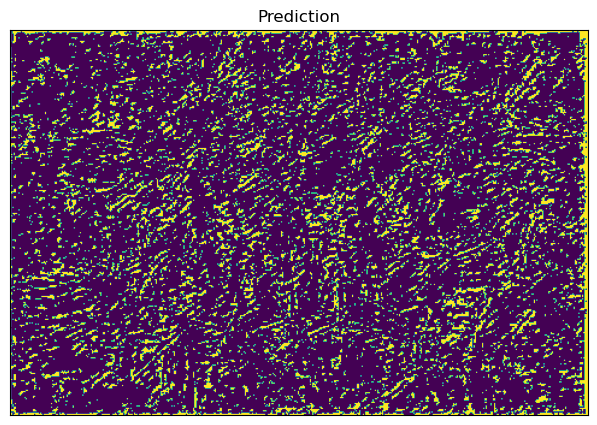

In [34]:
predict_image_only("/home/ps/leaf_seg/test_dataset/raw/02.JPG", model3)

In [ ]:
visualize(sam =)

IOU 0.7822201251983643


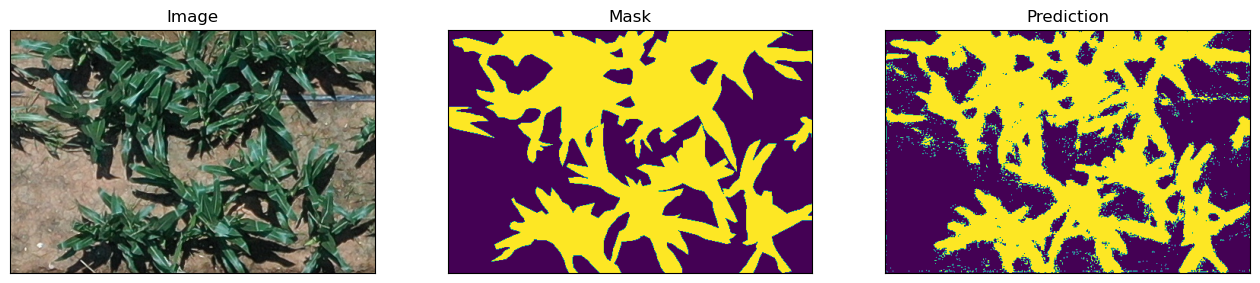

In [20]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/02.JPG", "/home/ps/leaf_seg/test_dataset/mask_human/01.png",model3)

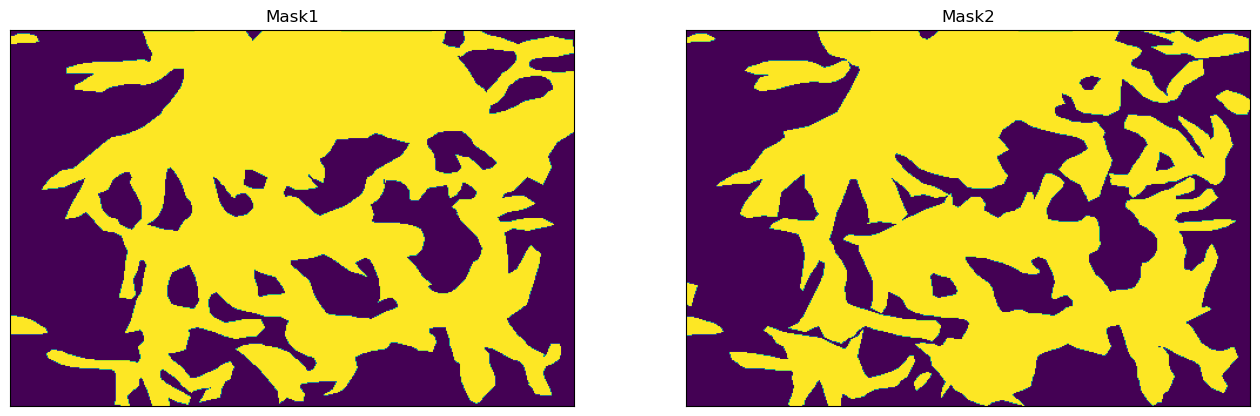

0.8235496878623962

In [17]:
# 比较人为误差
def compare_mask(dir1, dir2):
    to_tensor = ToTensor()
    m1 = Image.open(dir1).convert('L')
    m2 = Image.open(dir2).convert('L')
    m1_array = np.array(m1)
    m1_tensor = to_tensor( m1_array).squeeze()
    m2_array = np.array(m2)
    m2_tensor = to_tensor( m2_array).squeeze()
    #print(m1_tensor.shape, m2_tensor.shape)
    #continue
    iou = iou_2d(m1_tensor, m2_tensor)
    visualize(mask1=m1, mask2=m2)
    return iou 

compare_mask("/home/ps/leaf_seg/test_dataset/mask_human/07.png","/home/ps/leaf_seg/test_dataset/07_2.png" )

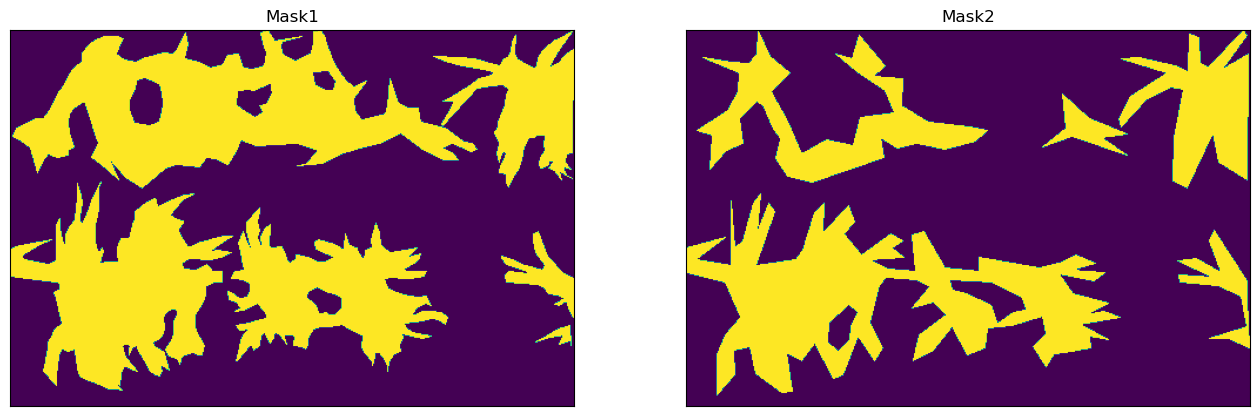

0.6125192642211914

In [18]:
compare_mask("/home/ps/leaf_seg/test_dataset/mask_human/08.png","/home/ps/leaf_seg/test_dataset/mask2/08.png" )


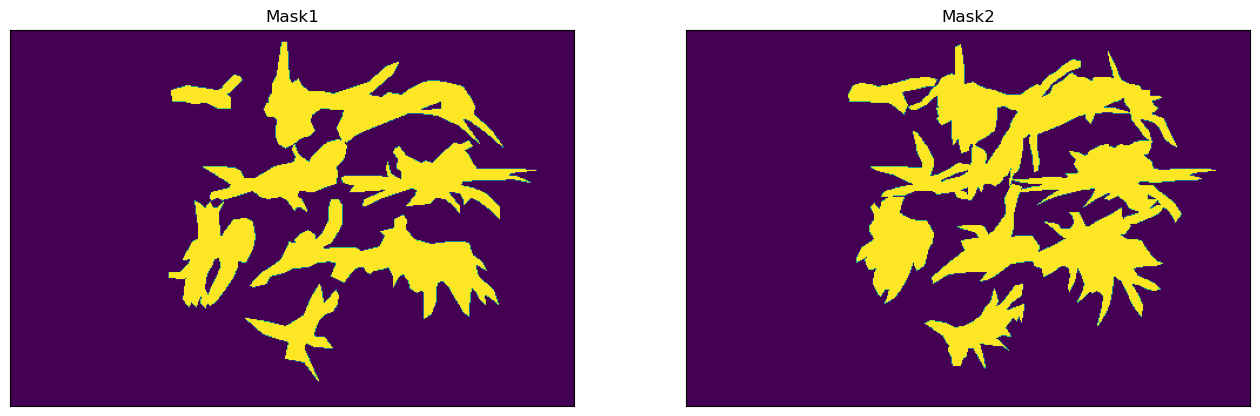

0.6646258234977722

In [19]:
compare_mask("/home/ps/leaf_seg/test_dataset/mask_human/14.png","/home/ps/leaf_seg/test_dataset/mask2/14.png" )


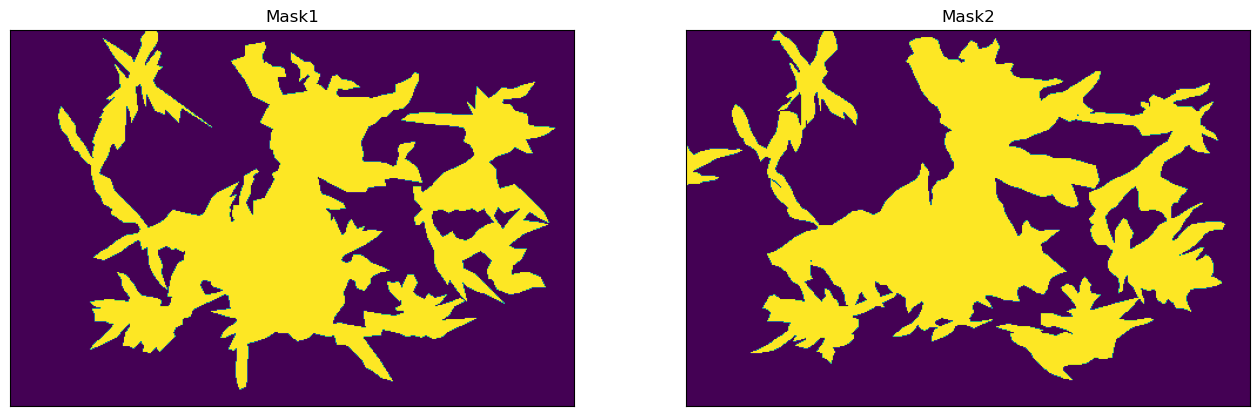

0.7165594100952148

In [20]:
compare_mask("/home/ps/leaf_seg/test_dataset/mask_human/16.png","/home/ps/leaf_seg/test_dataset/mask2/16.png" )

IOU 0.4082864224910736


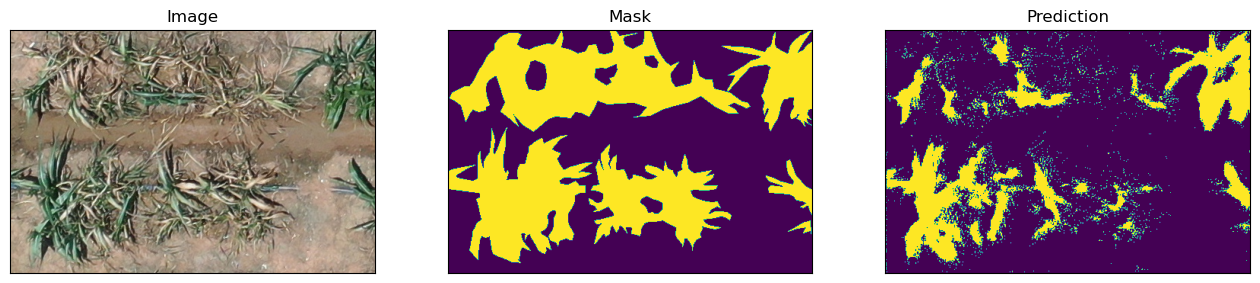

In [18]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/08.JPG", "/home/ps/leaf_seg/test_dataset/mask_human/08.png",model3)

IOU 0.5190531015396118


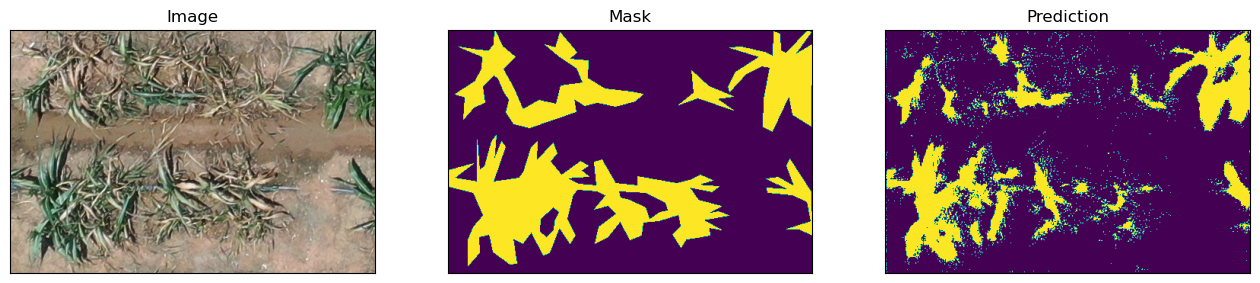

In [19]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/08.JPG", "/home/ps/leaf_seg/test_dataset/mask2/08.png",model3)

IOU 0.27185335755348206


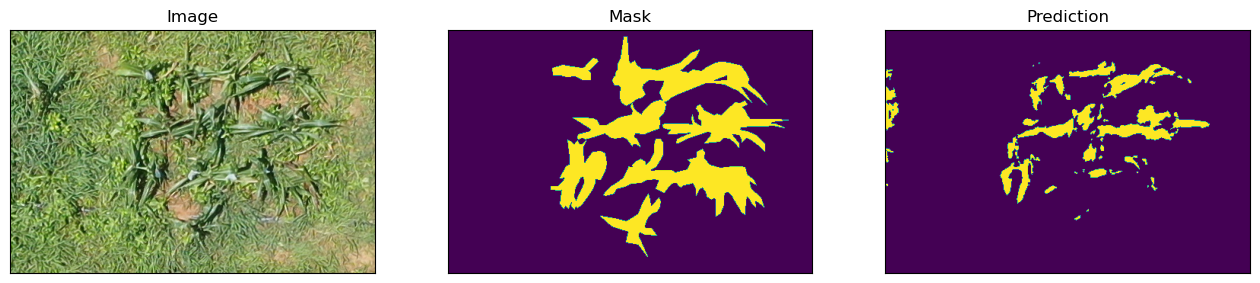

In [23]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/14.JPG", "/home/ps/leaf_seg/test_dataset/mask_human/14.png",model2)

IOU 0.2502325773239136


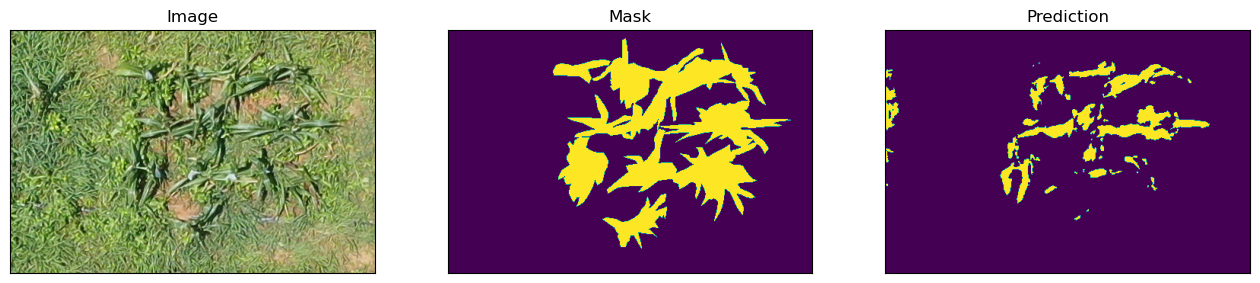

In [27]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/14.JPG", "/home/ps/leaf_seg/test_dataset/mask2/14.png",model2)

IOU 0.34331709146499634


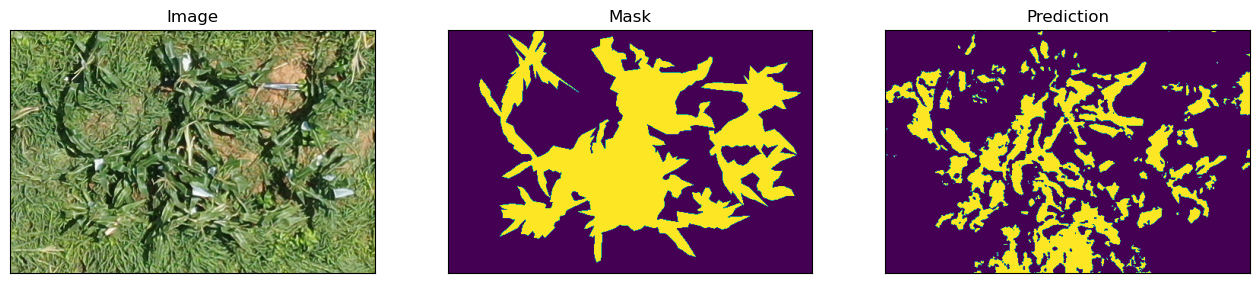

In [25]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/16.JPG", "/home/ps/leaf_seg/test_dataset/mask_human/16.png",model2)

IOU 0.31354251503944397


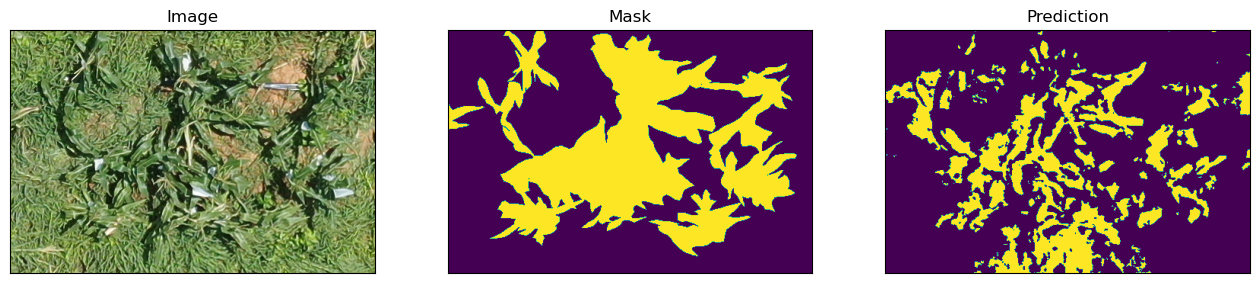

In [28]:
predict_image_no_resize_withmask("/home/ps/leaf_seg/test_dataset/raw/16.JPG", "/home/ps/leaf_seg/test_dataset/mask2/16.png",model2)